# Model selection 2 - Ecosystem sensitivity to precip and aridity

Using domain as a random effect (NEON domain as fixed effect tried in [this notebook](sensitivity_fixedDomain.ipynb)).

This model selection routing identifies the best linear mixed model for NDVIint as a function of precip, ZNDVIint as a function of precip, and ZNDVIint as a function of SPEI. There are a few problems with these models. 

1. The residuals are heavy tailed (see q-q plots), indicating that this is non-normal data. Some ways to approach this might be:

    - transform the data (see here: https://stats.stackexchange.com/questions/283375/violated-normality-of-residuals-assumption-in-linear-mixed-model)
    - use a glmm (glmer from lme4 library does this)

2. Its difficult to get model uncertainties from lme objects. Other model packages (lmer in lme4) ay do this) but do not offer specification of an autoregressive correlation model. Options for this might be:

    - Calculate RMSE from the residuals
    - Use a lmer or glmer and ignore the autoregressive nature of the data.
    
The [MS3_randD.ipynb](MS3_randD.ipynb) notebook has some trials to try to fix these.

## Load packages and data

In [1]:
library('ggplot2')
library('repr')
library('dplyr')
library('nlme')

source('common_stats_functions.r')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

Loading required package: sp
rgdal: version: 1.4-7, (SVN revision 845)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.4.3, released 2019/10/28
 Path to GDAL shared files: /usr/share/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 6.2.1, November 1st, 2019, [PJ_VERSION: 620]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-1 


OGR data source with driver: ESRI Shapefile 
Source: "/home/greg/data/GD_gregmaurer/droughtnet_precipsens_data/NEONdomains", layer: "NEON_Domains"
with 22 features
It has 6 fields


Regions defined for each Polygons


In [2]:
# Get the sensitivity statistics dataframe and
# the long-term USHCN statistics datafame
df <- sensitivity_stats_df()
dim(df)
df2 <- longterm_climate_df()
dim(df2)

[1] "Loading ~/GD_gregmaurer/droughtnet_precipsens_data/MODIS/annual_ushcn_NDVI.csv"


Parsed with column specification:
cols(
  stationid = col_character(),
  year = col_double(),
  ndvi_mean = col_double(),
  ndvi_max = col_double(),
  ndvi_min = col_double(),
  ndvi_sum = col_double(),
  zndvi_mean = col_double(),
  zndvi_max = col_double(),
  zndvi_min = col_double(),
  zndvi_sum = col_double(),
  ndvi_gsmean = col_double(),
  ndvi_gssum = col_double(),
  zndvi_gsmean = col_double(),
  zndvi_gssum = col_double()
)


[1] "Loading ~/GD_gregmaurer/droughtnet_precipsens_data/USHCN_derived/annual_ushcn_spei_allstations.csv"


Parsed with column specification:
cols(
  .default = col_double(),
  stationid = col_character()
)
See spec(...) for full column specifications.


[1] "Loading ~/GD_gregmaurer/droughtnet_precipsens_data/USHCN_derived/allyr_ushcn_calcs_allstations.csv"


Parsed with column specification:
cols(
  .default = col_double(),
  stationid = col_character(),
  elev = col_character(),
  state = col_character(),
  name = col_character(),
  flag1 = col_character(),
  flag2 = col_character(),
  flag3 = col_character()
)
See spec(...) for full column specifications.


[1] "Assigning NEON domain names to locCalcs dataframe..."
OGR data source with driver: ESRI Shapefile 
Source: "/home/greg/data/GD_gregmaurer/droughtnet_precipsens_data/NEONdomains", layer: "NEON_Domains"
with 22 features
It has 6 fields
[1] "Loading ~/GD_gregmaurer/droughtnet_precipsens_data/MODIS/annual_ushcn_eeMODIS.csv"


Parsed with column specification:
cols(
  .default = col_double(),
  stationid = col_character(),
  date = col_datetime(format = "")
)
See spec(...) for full column specifications.


[1] "Subsetting SPEI (>1999) and merging three dataframes..."
[1] "Removing 160 rows missing domain names..."


[1] 19328    94

[1] "Loading ~/GD_gregmaurer/droughtnet_precipsens_data/USHCN_derived/annual_ushcn_spei_allstations.csv"


Parsed with column specification:
cols(
  .default = col_double(),
  stationid = col_character()
)
See spec(...) for full column specifications.


[1] "Loading ~/GD_gregmaurer/droughtnet_precipsens_data/USHCN_derived/allyr_ushcn_calcs_allstations.csv"


Parsed with column specification:
cols(
  .default = col_double(),
  stationid = col_character(),
  elev = col_character(),
  state = col_character(),
  name = col_character(),
  flag1 = col_character(),
  flag2 = col_character(),
  flag3 = col_character()
)
See spec(...) for full column specifications.


[1] "Assigning NEON domain names to locCalcs dataframe..."
OGR data source with driver: ESRI Shapefile 
Source: "/home/greg/data/GD_gregmaurer/droughtnet_precipsens_data/NEONdomains", layer: "NEON_Domains"
with 22 features
It has 6 fields
[1] "Merging two dataframes..."
[1] "Removing 1300 rows missing domain names..."


[1] 151542     55

## Models for annual summed ndvi (NDVIint) vs precip

In [3]:
# Set an optimization parameter - not quite sure why
ctrl <- lmeControl(opt='optim')
# ndvi_sum ~ prcp_sum, random slope and intercept by statioon
ndviprcp_StaRand <- lme(ndvi_sum ~ prcp_sum, random=~1+prcp_sum|stationid,
                        data=df, na.action=na.omit)
# ndvi_sum ~ prcp_sum + neonDomainName, random slope and intercept by stationid
ndviprcp_DFixed_StaRand <- lme(ndvi_sum ~ prcp_sum + neonDomainName,
                               random=~1+prcp_sum|stationid,
                               data=df, na.action=na.omit)
# ndvi_sum ~ prcp_sum * neonDomainName, random slope and intercept by stationid
ndviprcp_DFixedInt_StaRand <- lme(ndvi_sum ~ prcp_sum * neonDomainName,
                                  random=~1+prcp_sum|stationid,
                                  data=df, na.action=na.omit)

# ndvi_sum ~ prcp_sum, random slope and intercept by domain
ndviprcp_DomRand <- lme(ndvi_sum ~ prcp_sum, random=~1+prcp_sum|neonDomainName,
                        data=df, na.action=na.omit)
# ndvi_sum ~ prcp_sum + neonDomainName, random slope and intercept by domain
ndviprcp_DFixed_DomRand <- lme(ndvi_sum ~ prcp_sum + neonDomainName,
                               random=~1+prcp_sum|neonDomainName,
                               data=df, na.action=na.omit)
# ndvi_sum ~ prcp_sum * neonDomainName, random slope and intercept by domain
ndviprcp_DFixedInt_DomRand <- lme(ndvi_sum ~ prcp_sum * neonDomainName,
                                  random=~1+prcp_sum|neonDomainName,
                                  control=ctrl, data=df, na.action=na.omit)

# ndvi_sum ~ prcp_sum, random slope and intercept by domain/stationid
ndviprcp_DomStaRand <- lme(ndvi_sum ~ prcp_sum, random=~1+prcp_sum|neonDomainName/stationid,
                           data=df, na.action=na.omit)
# ndvi_sum ~ prcp_sum + neonDomainName, random slope and intercept by domain/stationid
ndviprcp_DFixed_DomStaRand <- lme(ndvi_sum ~ prcp_sum + neonDomainName,
                                  random=~1+prcp_sum|neonDomainName/stationid,
                                  data=df, na.action=na.omit)
# ndvi_sum ~ prcp_sum * neonDomainName, random slope and intercept by domain/stationid
ndviprcp_DFixedInt_DomStaRand <- lme(ndvi_sum ~ prcp_sum * neonDomainName,
                                     random=~1+prcp_sum|neonDomainName/stationid,
                                     data=df, na.action=na.omit)

data.frame(AIC=c(
AIC(ndviprcp_StaRand),
AIC(ndviprcp_DFixed_StaRand),
AIC(ndviprcp_DFixedInt_StaRand),
AIC(ndviprcp_DomRand),
AIC(ndviprcp_DFixed_DomRand),
AIC(ndviprcp_DFixedInt_DomRand),
AIC(ndviprcp_DomStaRand),
AIC(ndviprcp_DFixed_DomStaRand),
AIC(ndviprcp_DFixedInt_DomStaRand)),
BIC=c(
BIC(ndviprcp_StaRand),
BIC(ndviprcp_DFixed_StaRand),
BIC(ndviprcp_DFixedInt_StaRand),
BIC(ndviprcp_DomRand),
BIC(ndviprcp_DFixed_DomRand),
BIC(ndviprcp_DFixedInt_DomRand),
BIC(ndviprcp_DomStaRand),# ***
BIC(ndviprcp_DFixed_DomStaRand),
BIC(ndviprcp_DFixedInt_DomStaRand)))

AIC,BIC
<dbl>,<dbl>
325.2675,372.2498
-303.8147,-131.5653
-1020.7909,-723.3019
46125.8641,46172.8464
46111.3210,46283.5704
46295.1548,46592.6438
-1241.2803,-1170.8069
-1237.0576,-1041.3196
-1014.7909,-693.8160


In [4]:
# Same models but with AR1 correlation structure
# ndvi_sum ~ prcp_sum, random slope and intercept by statioon
ndviprcp_AR_StaRand <- lme(ndvi_sum ~ prcp_sum, random=~1+prcp_sum|stationid,
                        correlation=corAR1(),
                        data=df, na.action=na.omit)
# ndvi_sum ~ prcp_sum + neonDomainName, random slope and intercept by stationid
ndviprcp_AR_DFixed_StaRand <- lme(ndvi_sum ~ prcp_sum + neonDomainName,
                               random=~1+prcp_sum|stationid,
                               correlation=corAR1(),
                               data=df, na.action=na.omit)
# ndvi_sum ~ prcp_sum * neonDomainName, random slope and intercept by stationid
ndviprcp_AR_DFixedInt_StaRand <- lme(ndvi_sum ~ prcp_sum * neonDomainName,
                                  random=~1+prcp_sum|stationid,
                                  correlation=corAR1(),
                                  data=df, na.action=na.omit)

# ndvi_sum ~ prcp_sum, random slope and intercept by domain
ndviprcp_AR_DomRand <- lme(ndvi_sum ~ prcp_sum, random=~1+prcp_sum|neonDomainName,
                        correlation=corAR1(),
                        data=df, na.action=na.omit)
# ndvi_sum ~ prcp_sum + neonDomainName, random slope and intercept by domain
ndviprcp_AR_DFixed_DomRand <- lme(ndvi_sum ~ prcp_sum + neonDomainName,
                               random=~1+prcp_sum|neonDomainName,
                               correlation=corAR1(),
                               data=df, na.action=na.omit)
# ndvi_sum ~ prcp_sum * neonDomainName, random slope and intercept by domain
ndviprcp_AR_DFixedInt_DomRand <- lme(ndvi_sum ~ prcp_sum * neonDomainName,
                                  random=~1+prcp_sum|neonDomainName,
                                  correlation=corAR1(),
                                  data=df, na.action=na.omit)

# ndvi_sum ~ prcp_sum, random slope and intercept by domain/stationid
ndviprcp_AR_DomStaRand <- lme(ndvi_sum ~ prcp_sum, random=~1+prcp_sum|neonDomainName/stationid,
                           correlation=corAR1(),
                           data=df, na.action=na.omit)
# ndvi_sum ~ prcp_sum + neonDomainName, random slope and intercept by domain/stationid
ndviprcp_AR_DFixed_DomStaRand <- lme(ndvi_sum ~ prcp_sum + neonDomainName,
                                  random=~1+prcp_sum|neonDomainName/stationid,
                                  correlation=corAR1(),
                                  data=df, na.action=na.omit)
# ndvi_sum ~ prcp_sum * neonDomainName, random slope and intercept by domain/stationid
ndviprcp_AR_DFixedInt_DomStaRand <- lme(ndvi_sum ~ prcp_sum * neonDomainName,
                                     random=~1+prcp_sum|neonDomainName/stationid,
                                     correlation=corAR1(),
                                     data=df, na.action=na.omit)
data.frame(AIC=c(
AIC(ndviprcp_AR_StaRand),
AIC(ndviprcp_AR_DFixed_StaRand),
AIC(ndviprcp_AR_DFixedInt_StaRand),
AIC(ndviprcp_AR_DomRand),
AIC(ndviprcp_AR_DFixed_DomRand),
AIC(ndviprcp_AR_DFixedInt_DomRand),
AIC(ndviprcp_AR_DomStaRand),
AIC(ndviprcp_AR_DFixed_DomStaRand),
AIC(ndviprcp_AR_DFixedInt_DomStaRand)),
BIC=c(
BIC(ndviprcp_AR_StaRand),
BIC(ndviprcp_AR_DFixed_StaRand),
BIC(ndviprcp_AR_DFixedInt_StaRand),
BIC(ndviprcp_AR_DomRand),
BIC(ndviprcp_AR_DFixed_DomRand),
BIC(ndviprcp_AR_DFixedInt_DomRand),
BIC(ndviprcp_AR_DomStaRand),# ***
BIC(ndviprcp_AR_DFixed_DomStaRand),
BIC(ndviprcp_AR_DFixedInt_DomStaRand)))

AIC,BIC
<dbl>,<dbl>
-512.0663,-457.2537
-1144.5291,-964.4502
-1888.2794,-1582.9618
16887.4243,16942.2370
16885.4957,17065.5746
17103.3308,17408.6484
-2109.0787,-2030.7749
-2106.6910,-1903.1235
-1882.2794,-1553.4758


## Best NDVIint ~ Precip model

In [5]:
# (ndviprcp_AR_DomStaRand) ndvi_sum ~ prcp_sum, random slope and intercept by domain/stationid
ndviprcp_best <- lme(ndvi_sum ~ prcp_sum, random=~1+prcp_sum|neonDomainName/stationid,
                           correlation=corAR1(),
                           data=df, na.action=na.omit)
summary(ndviprcp_best)

Linear mixed-effects model fit by REML
 Data: df 
        AIC       BIC   logLik
  -2109.079 -2030.775 1064.539

Random effects:
 Formula: ~1 + prcp_sum | neonDomainName
 Structure: General positive-definite, Log-Cholesky parametrization
            StdDev       Corr  
(Intercept) 1.5788839294 (Intr)
prcp_sum    0.0005398293 -0.939

 Formula: ~1 + prcp_sum | stationid %in% neonDomainName
 Structure: General positive-definite, Log-Cholesky parametrization
            StdDev       Corr  
(Intercept) 0.9607603863 (Intr)
prcp_sum    0.0002403693 -0.565
Residual    0.1959650693       

Correlation Structure: AR(1)
 Formula: ~1 | neonDomainName/stationid 
 Parameter estimate(s):
      Phi 
0.2531896 
Fixed effects: ndvi_sum ~ prcp_sum 
               Value Std.Error    DF   t-value p-value
(Intercept) 5.558747 0.3854807 17429 14.420297       0
prcp_sum    0.000539 0.0001321 17429  4.081708       0
 Correlation: 
         (Intr)
prcp_sum -0.933

Standardized Within-Group Residuals:
          

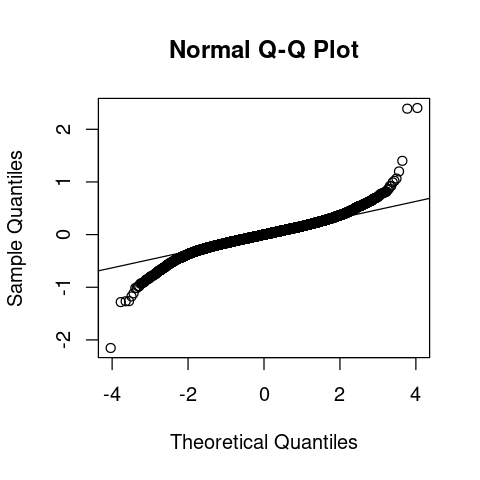

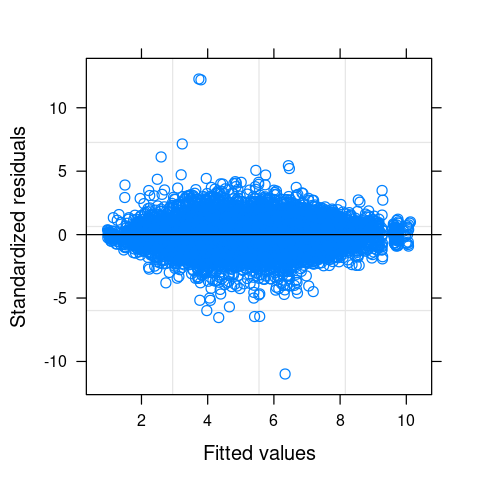

In [6]:
options(repr.plot.width=4, repr.plot.height=4)
qqnorm(resid(ndviprcp_best))
qqline(resid(ndviprcp_best))
plot(ndviprcp_best)

## Models for annual summed zndvi vs precip

In [7]:
# Set an optimization parameter - not quite sure why
ctrl <- lmeControl(opt='optim')

# zndvi_sum ~ prcp_sum, random slope and intercept by statioon
zndviprcp_StaRand <- lme(zndvi_sum ~ prcp_sum, random=~1+prcp_sum|stationid,
                        data=df, na.action=na.omit)
# zndvi_sum ~ prcp_sum + neonDomainName, random slope and intercept by stationid
zndviprcp_DFixed_StaRand <- lme(zndvi_sum ~ prcp_sum + neonDomainName,
                               random=~1+prcp_sum|stationid,
                               data=df, na.action=na.omit)
# zndvi_sum ~ prcp_sum * neonDomainName, random slope and intercept by stationid
zndviprcp_DFixedInt_StaRand <- lme(zndvi_sum ~ prcp_sum * neonDomainName,
                                  random=~1+prcp_sum|stationid,
                                  data=df, na.action=na.omit)

# zndvi_sum ~ prcp_sum, random slope and intercept by domain
zndviprcp_DomRand <- lme(zndvi_sum ~ prcp_sum, random=~1+prcp_sum|neonDomainName,
                         control=ctrl,data=df, na.action=na.omit)
# zndvi_sum ~ prcp_sum + neonDomainName, random slope and intercept by domain
zndviprcp_DFixed_DomRand <- lme(zndvi_sum ~ prcp_sum + neonDomainName,
                                random=~1+prcp_sum|neonDomainName,
                                control=ctrl, data=df, na.action=na.omit)
# zndvi_sum ~ prcp_sum * neonDomainName, random slope and intercept by domain
zndviprcp_DFixedInt_DomRand <- lme(zndvi_sum ~ prcp_sum * neonDomainName,
                                   random=~1+prcp_sum|neonDomainName,
                                   control=ctrl, data=df, na.action=na.omit)

# zndvi_sum ~ prcp_sum, random slope and intercept by domain/stationid
zndviprcp_DomStaRand <- lme(zndvi_sum ~ prcp_sum, random=~1+prcp_sum|neonDomainName/stationid,
                            control=ctrl, data=df, na.action=na.omit)
# zndvi_sum ~ prcp_sum + neonDomainName, random slope and intercept by domain/stationid
zndviprcp_DFixed_DomStaRand <- lme(zndvi_sum ~ prcp_sum + neonDomainName,
                                   random=~1+prcp_sum|neonDomainName/stationid,
                                   control=ctrl, data=df, na.action=na.omit)
# zndvi_sum ~ prcp_sum * neonDomainName, random slope and intercept by domain/stationid
zndviprcp_DFixedInt_DomStaRand <- lme(zndvi_sum ~ prcp_sum * neonDomainName,
                                      random=~1+prcp_sum|neonDomainName/stationid,
                                      control=ctrl, data=df, na.action=na.omit)

data.frame(AIC=c(
AIC(zndviprcp_StaRand),
AIC(zndviprcp_DFixed_StaRand),
AIC(zndviprcp_DFixedInt_StaRand),
AIC(zndviprcp_DomRand),
AIC(zndviprcp_DFixed_DomRand),
AIC(zndviprcp_DFixedInt_DomRand),
AIC(zndviprcp_DomStaRand),
AIC(zndviprcp_DFixed_DomStaRand),
AIC(zndviprcp_DFixedInt_DomStaRand)),
BIC=c(
BIC(zndviprcp_StaRand),
BIC(zndviprcp_DFixed_StaRand),
BIC(zndviprcp_DFixedInt_StaRand),
BIC(zndviprcp_DomRand),
BIC(zndviprcp_DFixed_DomRand),
BIC(zndviprcp_DFixedInt_DomRand),
BIC(zndviprcp_DomStaRand),# ***
BIC(zndviprcp_DFixed_DomStaRand),
BIC(zndviprcp_DFixedInt_DomStaRand)))

AIC,BIC
<dbl>,<dbl>
90889.88,90936.86
90601.48,90773.73
89673.13,89970.61
89533.73,89580.71
89510.97,89683.22
89673.13,89970.61
89540.66,89611.13
89516.97,89712.70
89679.13,90000.10


In [8]:
# Same as above but with AR1 correlation structure
# zndvi_sum ~ prcp_sum, random slope and intercept by statioon
zndviprcp_AR_StaRand <- lme(zndvi_sum ~ prcp_sum, random=~1+prcp_sum|stationid,
                         correlation=corAR1(),
                        data=df, na.action=na.omit)
# zndvi_sum ~ prcp_sum + neonDomainName, random slope and intercept by stationid
zndviprcp_AR_DFixed_StaRand <- lme(zndvi_sum ~ prcp_sum + neonDomainName,
                                correlation=corAR1(),
                               random=~1+prcp_sum|stationid,
                               data=df, na.action=na.omit)
# zndvi_sum ~ prcp_sum * neonDomainName, random slope and intercept by stationid
zndviprcp_AR_DFixedInt_StaRand <- lme(zndvi_sum ~ prcp_sum * neonDomainName,
                                   correlation=corAR1(),
                                  random=~1+prcp_sum|stationid,
                                  data=df, na.action=na.omit)

# zndvi_sum ~ prcp_sum, random slope and intercept by domain
zndviprcp_AR_DomRand <- lme(zndvi_sum ~ prcp_sum, random=~1+prcp_sum|neonDomainName,
                         correlation=corAR1(),
                         control=ctrl,data=df, na.action=na.omit)
# zndvi_sum ~ prcp_sum + neonDomainName, random slope and intercept by domain
zndviprcp_AR_DFixed_DomRand <- lme(zndvi_sum ~ prcp_sum + neonDomainName,
                                correlation=corAR1(),
                                random=~1+prcp_sum|neonDomainName,
                                control=ctrl, data=df, na.action=na.omit)
# zndvi_sum ~ prcp_sum * neonDomainName, random slope and intercept by domain
zndviprcp_AR_DFixedInt_DomRand <- lme(zndvi_sum ~ prcp_sum * neonDomainName,
                                   correlation=corAR1(),
                                   random=~1+prcp_sum|neonDomainName,
                                   control=ctrl, data=df, na.action=na.omit)

# zndvi_sum ~ prcp_sum, random slope and intercept by domain/stationid
zndviprcp_AR_DomStaRand <- lme(zndvi_sum ~ prcp_sum, random=~1+prcp_sum|neonDomainName/stationid,
                            correlation=corAR1(),
                            control=ctrl, data=df, na.action=na.omit)
# zndvi_sum ~ prcp_sum + neonDomainName, random slope and intercept by domain/stationid
zndviprcp_AR_DFixed_DomStaRand <- lme(zndvi_sum ~ prcp_sum + neonDomainName,
                                   correlation=corAR1(),
                                   random=~1+prcp_sum|neonDomainName/stationid,
                                   control=ctrl, data=df, na.action=na.omit)
# zndvi_sum ~ prcp_sum * neonDomainName, random slope and intercept by domain/stationid
zndviprcp_AR_DFixedInt_DomStaRand <- lme(zndvi_sum ~ prcp_sum * neonDomainName,
                                      correlation=corAR1(),
                                      random=~1+prcp_sum|neonDomainName/stationid,
                                      control=ctrl, data=df, na.action=na.omit)

data.frame(AIC=c(
AIC(zndviprcp_AR_StaRand),
AIC(zndviprcp_AR_DFixed_StaRand),
AIC(zndviprcp_AR_DFixedInt_StaRand),
AIC(zndviprcp_AR_DomRand),
AIC(zndviprcp_AR_DFixed_DomRand),
AIC(zndviprcp_AR_DFixedInt_DomRand),
AIC(zndviprcp_AR_DomStaRand),
AIC(zndviprcp_AR_DFixed_DomStaRand),
AIC(zndviprcp_AR_DFixedInt_DomStaRand)),
BIC=c(
BIC(zndviprcp_AR_StaRand),
BIC(zndviprcp_AR_DFixed_StaRand),
BIC(zndviprcp_AR_DFixedInt_StaRand),
BIC(zndviprcp_AR_DomRand),
BIC(zndviprcp_AR_DFixed_DomRand),
BIC(zndviprcp_AR_DFixedInt_DomRand),
BIC(zndviprcp_AR_DomStaRand),#***
BIC(zndviprcp_AR_DFixed_DomStaRand),
BIC(zndviprcp_AR_DFixedInt_DomStaRand)))

AIC,BIC
<dbl>,<dbl>
90064.78,90119.59
89760.60,89940.68
88526.10,88831.42
88544.25,88599.06
88516.11,88696.19
88671.17,88976.49
88405.03,88483.33
88377.17,88580.74
88532.12,88860.92


## Best summed zNDVI ~ Precip model

In [9]:
# Change optimizer - not quite sure why this works better
ctrl <- lmeControl(opt='optim')

# (zndviprcp_AR_DomStaRand) zndvi_sum ~ prcp_sum, random slope and intercept by domain/stationid
zndviprcp_best <- lme(zndvi_sum ~ prcp_sum, random=~1+prcp_sum|neonDomainName/stationid,
                      correlation=corAR1(),
                      control=ctrl, 
                      data=df, na.action=na.omit)

summary(zndviprcp_best)

Linear mixed-effects model fit by REML
 Data: df 
       AIC      BIC    logLik
  88405.03 88483.33 -44192.51

Random effects:
 Formula: ~1 + prcp_sum | neonDomainName
 Structure: General positive-definite, Log-Cholesky parametrization
            StdDev      Corr  
(Intercept) 2.118161482 (Intr)
prcp_sum    0.004733229 -0.736

 Formula: ~1 + prcp_sum | stationid %in% neonDomainName
 Structure: General positive-definite, Log-Cholesky parametrization
            StdDev       Corr  
(Intercept) 9.269913e-03 (Intr)
prcp_sum    1.548898e-05 -0.055
Residual    2.681223e+00       

Correlation Structure: AR(1)
 Formula: ~1 | neonDomainName/stationid 
 Parameter estimate(s):
      Phi 
0.2610559 
Fixed effects: zndvi_sum ~ prcp_sum 
                 Value Std.Error    DF   t-value p-value
(Intercept) -1.9477245 0.5260651 17429 -3.702440  0.0002
prcp_sum     0.0037721 0.0011546 17429  3.267103  0.0011
 Correlation: 
         (Intr)
prcp_sum -0.733

Standardized Within-Group Residuals:
        

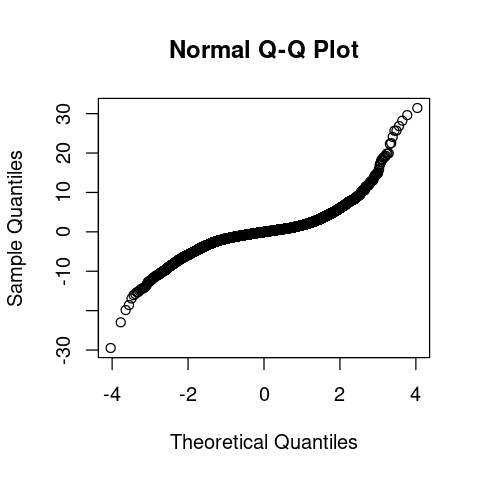

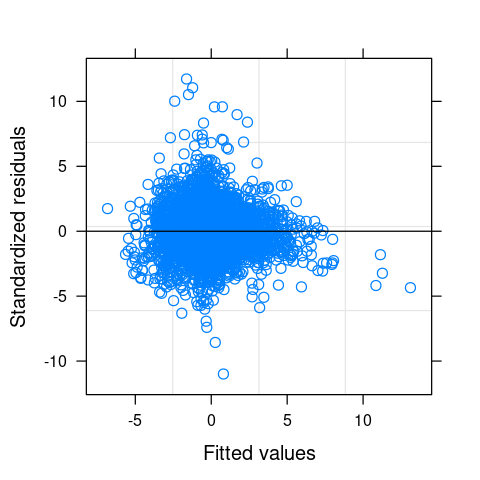

In [10]:
qqnorm(resid(zndviprcp_best))
plot(zndviprcp_best)

In [11]:
# Look how small the random stationid effects are here!!!
zndviprcp_best$coefficients$fixed
max(zndviprcp_best$coefficients$random$neonDomainName[,'prcp_sum'])
min(zndviprcp_best$coefficients$random$neonDomainName[,'prcp_sum'])
max(zndviprcp_best$coefficients$random$stationid[,'prcp_sum'])
min(zndviprcp_best$coefficients$random$stationid[,'prcp_sum'])

(Intercept)     prcp_sum 
-1.947724493  0.003772118

[1] 0.01260312

[1] -0.004344312

[1] 9.272975e-07

[1] -1.3526e-06

## Models for annual summed zndvi vs SPEI

In [12]:
# zndvi_sum ~ spei12mo_mean, random slope and intercept by statioon
zndvispei_StaRand <- lme(zndvi_sum ~ spei12mo_mean, random=~1+spei12mo_mean|stationid,
                        data=df, na.action=na.omit)
# zndvi_sum ~ spei12mo_mean + neonDomainName, random slope and intercept by stationid
# NOT WORKING!!!????
#zndvispei_DFixed_StaRand <- lme(zndvi_sum ~ spei12mo_mean + neonDomainName,
#                               random=~1+spei12mo_mean|stationid,control=ctrl,
#                               data=df, na.action=na.omit)
# zndvi_sum ~ spei12mo_mean * neonDomainName, random slope and intercept by stationid
zndvispei_DFixedInt_StaRand <- lme(zndvi_sum ~ spei12mo_mean * neonDomainName,
                                  random=~1+spei12mo_mean|stationid,control=ctrl,
                                  data=df, na.action=na.omit)

# zndvi_sum ~ spei12mo_mean, random slope and intercept by domain
zndvispei_DomRand <- lme(zndvi_sum ~ spei12mo_mean, random=~1+spei12mo_mean|neonDomainName,
                         control=ctrl,data=df, na.action=na.omit)
# zndvi_sum ~ spei12mo_mean + neonDomainName, random slope and intercept by domain
zndvispei_DFixed_DomRand <- lme(zndvi_sum ~ spei12mo_mean + neonDomainName,
                                random=~1+spei12mo_mean|neonDomainName,
                                control=ctrl, data=df, na.action=na.omit)
# zndvi_sum ~ spei12mo_mean * neonDomainName, random slope and intercept by domain
zndvispei_DFixedInt_DomRand <- lme(zndvi_sum ~ spei12mo_mean * neonDomainName,
                                   random=~1+spei12mo_mean|neonDomainName,
                                   control=ctrl, data=df, na.action=na.omit)

# zndvi_sum ~ spei12mo_mean, random slope and intercept by domain/stationid
zndvispei_DomStaRand <- lme(zndvi_sum ~ spei12mo_mean, random=~1+spei12mo_mean|neonDomainName/stationid,
                            control=ctrl, data=df, na.action=na.omit)
# zndvi_sum ~ spei12mo_mean + neonDomainName, random slope and intercept by domain/stationid
zndvispei_DFixed_DomStaRand <- lme(zndvi_sum ~ spei12mo_mean + neonDomainName,
                                   random=~1+spei12mo_mean|neonDomainName/stationid,
                                   control=ctrl, data=df, na.action=na.omit)
# zndvi_sum ~ spei12mo_mean * neonDomainName, random slope and intercept by domain/stationid
zndvispei_DFixedInt_DomStaRand <- lme(zndvi_sum ~ spei12mo_mean * neonDomainName,
                                      random=~1+spei12mo_mean|neonDomainName/stationid,
                                      control=ctrl, data=df, na.action=na.omit)


data.frame(AIC=c(
AIC(zndvispei_StaRand),
# Not working AIC(zndvispei_DFixed_StaRand),
AIC(zndvispei_DFixedInt_StaRand),
AIC(zndvispei_DomRand),
AIC(zndvispei_DFixed_DomRand),
AIC(zndvispei_DFixedInt_DomRand),
AIC(zndvispei_DomStaRand),
AIC(zndvispei_DFixed_DomStaRand),
AIC(zndvispei_DFixedInt_DomStaRand)),
BIC=c(
BIC(zndvispei_StaRand),
# Not working BIC(zndvispei_DFixed_StaRand),
BIC(zndvispei_DFixedInt_StaRand),
BIC(zndvispei_DomRand),
BIC(zndvispei_DFixed_DomRand),
BIC(zndvispei_DFixedInt_DomRand),
BIC(zndvispei_DomStaRand),#***
BIC(zndvispei_DFixed_DomStaRand),
BIC(zndvispei_DFixedInt_DomStaRand)))

AIC,BIC
<dbl>,<dbl>
86351.87,86398.86
84892.48,85189.97
85753.67,85800.65
85748.55,85920.80
85717.25,86014.74
84933.12,85003.59
84929.74,85125.48
84898.00,85218.97


In [13]:
# Same as above but with AR1 correlation
# zndvi_sum ~ spei12mo_mean, random slope and intercept by statioon
zndvispei_AR_StaRand <- lme(zndvi_sum ~ spei12mo_mean, random=~1+spei12mo_mean|stationid,
                         control=ctrl, correlation=corAR1(),
                         data=df, na.action=na.omit)
# zndvi_sum ~ spei12mo_mean + neonDomainName, random slope and intercept by stationid
zndvispei_AR_DFixed_StaRand <- lme(zndvi_sum ~ spei12mo_mean + neonDomainName,
                                random=~1+spei12mo_mean|stationid,control=ctrl,
                                correlation=corAR1(),
                                data=df, na.action=na.omit)
# zndvi_sum ~ spei12mo_mean * neonDomainName, random slope and intercept by stationid
#zndvispei_AR_DFixedInt_StaRand <- lme(zndvi_sum ~ spei12mo_mean * neonDomainName,
#                                  random=~1+spei12mo_mean|stationid,control=ctrl,
#                                   correlation=corAR1(),
#                                  data=df, na.action=na.omit)

# zndvi_sum ~ spei12mo_mean, random slope and intercept by domain
zndvispei_AR_DomRand <- lme(zndvi_sum ~ spei12mo_mean, random=~1+spei12mo_mean|neonDomainName,
                         correlation=corAR1(),
                         control=ctrl,data=df, na.action=na.omit)
# zndvi_sum ~ spei12mo_mean + neonDomainName, random slope and intercept by domain
zndvispei_AR_DFixed_DomRand <- lme(zndvi_sum ~ spei12mo_mean + neonDomainName,
                                random=~1+spei12mo_mean|neonDomainName,
                                correlation=corAR1(),
                                control=ctrl, data=df, na.action=na.omit)
# zndvi_sum ~ spei12mo_mean * neonDomainName, random slope and intercept by domain
zndvispei_AR_DFixedInt_DomRand <- lme(zndvi_sum ~ spei12mo_mean * neonDomainName,
                                   random=~1+spei12mo_mean|neonDomainName,
                                   correlation=corAR1(),
                                   control=ctrl, data=df, na.action=na.omit)

# zndvi_sum ~ spei12mo_mean, random slope and intercept by domain/stationid
zndvispei_AR_DomStaRand <- lme(zndvi_sum ~ spei12mo_mean, random=~1+spei12mo_mean|neonDomainName/stationid,
                            correlation=corAR1(),
                            control=ctrl, data=df, na.action=na.omit)
# zndvi_sum ~ spei12mo_mean + neonDomainName, random slope and intercept by domain/stationid
zndvispei_AR_DFixed_DomStaRand <- lme(zndvi_sum ~ spei12mo_mean + neonDomainName,
                                   random=~1+spei12mo_mean|neonDomainName/stationid,
                                   correlation=corAR1(),
                                   control=ctrl, data=df, na.action=na.omit)
# zndvi_sum ~ spei12mo_mean * neonDomainName, random slope and intercept by domain/stationid
#zndvispei_AR_DFixedInt_DomStaRand <- lme(zndvi_sum ~ spei12mo_mean * neonDomainName,
#                                      random=~1+spei12mo_mean|neonDomainName/stationid,
#                                      correlation=corAR1(),
#                                      control=ctrl, data=df, na.action=na.omit)

data.frame(AIC=c(
AIC(zndvispei_AR_StaRand),
AIC(zndvispei_AR_DFixed_StaRand),
# Not working AIC(zndvispei_AR_DFixedInt_StaRand)
AIC(zndvispei_AR_DomRand),
AIC(zndvispei_AR_DFixed_DomRand),
AIC(zndvispei_AR_DFixedInt_DomRand),
AIC(zndvispei_AR_DomStaRand),
AIC(zndvispei_AR_DFixed_DomStaRand)
# Not working AIC(zndvispei_AR_DFixedInt_DomStaRand)
),
BIC=c(
BIC(zndvispei_AR_StaRand),
BIC(zndvispei_AR_DFixed_StaRand),
# Not working BIC(zndvispei_AR_DFixedInt_StaRand),
BIC(zndvispei_AR_DomRand),
BIC(zndvispei_AR_DFixed_DomRand),
BIC(zndvispei_AR_DFixedInt_DomRand),
BIC(zndvispei_AR_DomStaRand), # ***
BIC(zndvispei_AR_DFixed_DomStaRand)
# Not working BIC(zndvispei_AR_DFixedInt_DomStaRand)
))

AIC,BIC
<dbl>,<dbl>
84715.15,84769.97
84334.78,84514.86
84400.36,84455.17
84391.60,84571.68
84356.93,84662.25
83302.32,83380.63
83294.64,83498.21


## Best summed zNDVI ~ Mean 12mon SPEI  model

In [14]:
# (zndvispei_AR_DomStaRand) zndvi_sum ~ spei12mo_mean, random slope and intercept by domain/stationid
zndvispei_best <- lme(zndvi_sum ~ spei12mo_mean, random=~1+spei12mo_mean|neonDomainName/stationid,
                            correlation=corAR1(),
                            control=ctrl, data=df, na.action=na.omit)

summary(zndvispei_best)

Linear mixed-effects model fit by REML
 Data: df 
       AIC      BIC    logLik
  83302.32 83380.63 -41641.16

Random effects:
 Formula: ~1 + spei12mo_mean | neonDomainName
 Structure: General positive-definite, Log-Cholesky parametrization
              StdDev   Corr  
(Intercept)   1.258772 (Intr)
spei12mo_mean 1.764350 0.812 

 Formula: ~1 + spei12mo_mean | stationid %in% neonDomainName
 Structure: General positive-definite, Log-Cholesky parametrization
              StdDev    Corr  
(Intercept)   0.4369555 (Intr)
spei12mo_mean 0.9612988 0.995 
Residual      2.3058602       

Correlation Structure: AR(1)
 Formula: ~1 | neonDomainName/stationid 
 Parameter estimate(s):
      Phi 
0.3291401 
Fixed effects: zndvi_sum ~ spei12mo_mean 
                  Value Std.Error    DF  t-value p-value
(Intercept)   0.7402265 0.3083357 17429 2.400716  0.0164
spei12mo_mean 1.3858123 0.4315194 17429 3.211472  0.0013
 Correlation: 
              (Intr)
spei12mo_mean 0.808 

Standardized Within-Group R

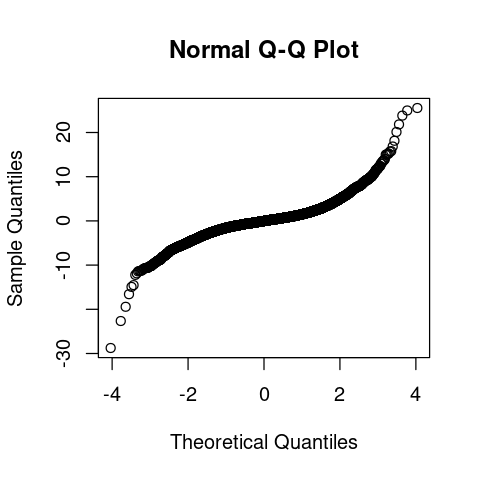

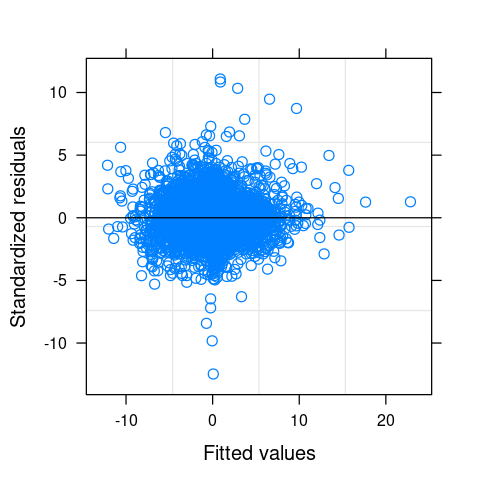

In [15]:
qqnorm(resid(zndvispei_best))
plot(zndvispei_best)

## Extract residuals and confidence intervals (just to see how)

This paper:

https://doi.org/10.1016/j.jml.2007.12.005

May be of interest regarding confidence intervals

In [16]:
# Return residuals
residuals(zndvispei_best, level=2, asList=T)[1]
confint <- intervals(zndvispei_best)
confint

$`Southeast/USH00011084`
          1           2           3           4           5           6 
 2.30575905  1.40067007  2.12227404  3.06954067  0.55151524 -3.75978246 
          7           8           9          10          11          12 
-3.57468827 -3.37918359 -1.86766618 -0.08500774 -2.21302449 -1.13736022 
         13          14          15          16 
 2.16873476  2.88582857  0.05414712  1.63222706

Approximate 95% confidence intervals

 Fixed effects:
                  lower      est.    upper
(Intercept)   0.1358576 0.7402265 1.344595
spei12mo_mean 0.5399912 1.3858123 2.231634
attr(,"label")
[1] "Fixed effects:"

 Random Effects:
  Level: neonDomainName 
                                   lower      est.    upper
sd((Intercept))                0.7565249 1.2587718 2.094454
sd(spei12mo_mean)              1.1329512 1.7643503 2.747631
cor((Intercept),spei12mo_mean) 0.5134384 0.8121599 0.935321
  Level: stationid 
                                   lower      est.     upper
sd((Intercept))                0.3730125 0.4369555 0.5118599
sd(spei12mo_mean)              0.8960685 0.9612988 1.0312776
cor((Intercept),spei12mo_mean) 0.9371224 0.9950209 0.9996163

 Correlation structure:
        lower      est.     upper
Phi 0.3134779 0.3291401 0.3446232
attr(,"label")
[1] "Correlation structure:"

 Within-group standard error:
   lower     est.    upper 
2.278905 2.305860 2.333135 

In [17]:
?intervals.lme

intervals.lme {nlme},R Documentation
object,"an object inheriting from class ""lme"", representing a fitted linear mixed-effects model."
level,an optional numeric value with the confidence level for the intervals. Defaults to 0.95.
which,"an optional character string specifying the subset of parameters for which to construct the confidence intervals. Possible values are ""all"" for all parameters, ""var-cov"" for the variance-covariance parameters only, and ""fixed"" for the fixed effects only. Defaults to ""all""."
...,some methods for this generic require additional arguments. None are used in this method.
fixed,"fixed effects, only present when which is not equal to ""var-cov""."
reStruct,"random effects variance-covariance parameters, only present when which is not equal to ""fixed""."
corStruct,"within-group correlation parameters, only present when which is not equal to ""fixed"" and a correlation structure is used in object."
varFunc,"within-group variance function parameters, only present when which is not equal to ""fixed"" and a variance function structure is used in object."
sigma,within-group standard deviation.


## Summarize and export eco-sensitivity models by domain

Using the BIC statistic showed that the models with neonDomainName/stationid and domain NOT as a fixed effect were the best-fitting models for ndvi vs precip, zndvi vs precip, and zndvi vs spei. Adding an AR1 correlation structure improved the model fits significantly (in both AIC and BIC).

Below are tables of the fixed effects and neonDomain random effects for each sensitivity.



In [18]:
# Get some mean annual statistics for domains (16year MAT/MAP)
gb_dom <- df %>% group_by(neonDomainName) %>%
            summarise(MAP=mean(prcp_sum, na.rm=TRUE),
                      MAT=mean(tavg_mean, na.rm=TRUE),
                      spei12mo_trend=mean(spei12mo_trend, na.rm=TRUE),
                      spei12mo_cv5yr_trend=mean(spei12mo_cv5yr_trend,na.rm=TRUE))

# Get some mean annual statistics for stationid (random effect, 16year MAT/MAP)
gb_sta <- df %>% group_by(stationid) %>%
            summarise(neonDomainName=unique(neonDomainName),
                      MAP=mean(prcp_sum, na.rm=TRUE),
                      MAT=mean(tavg_mean, na.rm=TRUE),
                      spei12mo_trend=mean(spei12mo_trend, na.rm=TRUE),
                      spei12mo_cv5yr_trend=mean(spei12mo_cv5yr_trend,na.rm=TRUE))


# This uses the function get_fe_2re to get fixed and random effects (and other stuff)
# out of the lme models. The function is in 'common_stats_functions'
ndviprcp <- get_fe_2re(ndviprcp_best, 'ndvi_prcp', 'neonDomainName', 'stationid')
ndviprcp_fe <- ndviprcp[[1]]
ndviprcp_re <- ndviprcp[[2]]

zndviprcp <- get_fe_2re(zndviprcp_best, 'zndvi_prcp', 'neonDomainName', 'stationid')
zndviprcp_fe <- zndviprcp[[1]]
zndviprcp_re <- zndviprcp[[2]]

zndvispei <- get_fe_2re(zndvispei_best, 'zndvi_spei', 'neonDomainName', 'stationid')
zndvispei_fe <- zndvispei[[1]]
zndvispei_re <- zndvispei[[2]]

In [19]:
#Join together 16yr domain stats, fixed and domain random effects for the 3 models
fe_dom_re <- list(gb_dom, ndviprcp_fe, zndviprcp_fe, zndvispei_fe) %>%
        Reduce(function(df1,df2) full_join(df1,df2,by="neonDomainName"), .)
#Join together 16yr station stats, and station random effects for the 3 models
sta_re <- list(gb_sta, ndviprcp_re, zndviprcp_re, zndvispei_re) %>%
        Reduce(function(df1,df2) left_join(df1,df2,by="stationid"), .)


fe_dom_re
head(sta_re)               

Warning message:
“Column `neonDomainName` joining factor and character vector, coercing into character vector”

neonDomainName,MAP,MAT,spei12mo_trend,spei12mo_cv5yr_trend,ndvi_prcp_Intcpt,ndvi_prcp_Slope,zndvi_prcp_Intcpt,zndvi_prcp_Slope,zndvi_spei_Intcpt,zndvi_spei_Slope
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Appalachians / Cumberland Plateau,1229.8583,12.876123,2.640105e-04,-2.193997e-05,1.52342480,-0.0004447813,1.25126637,-0.0031918669,-0.67302059,-1.4337369
Atlantic Neotropical,1502.0000,24.170295,-4.750003e-04,2.047066e-05,0.88324002,-0.0003521494,-0.02203213,-0.0023277159,-0.20360003,-0.6563070
Central Plains,497.7514,12.285118,-9.022957e-05,2.109924e-05,-1.93521276,0.0008730305,-3.39650714,0.0069627378,0.18856129,1.6487782
Desert Southwest,225.0551,19.144803,-8.694542e-04,1.476098e-04,-2.83927763,0.0009170556,-1.78918699,0.0126031203,4.33773470,4.2406899
Great Basin,308.4206,9.069863,-3.262137e-04,6.795495e-05,-1.57724547,0.0002376465,0.72017901,0.0002978784,0.26351350,0.3043271
Great Lakes,878.7050,7.559194,1.855930e-04,-1.993492e-05,0.67688186,-0.0004313319,1.54440225,-0.0032932772,-0.69952413,-1.3889019
Mid Atlantic,1157.1283,14.664712,-6.455362e-05,4.626216e-05,1.47599294,-0.0003757205,0.37273285,-0.0023877590,-0.64973248,-1.2016069
Northeast,1145.8539,8.846465,2.156314e-04,-5.588769e-06,1.70442740,-0.0006336817,2.48234353,-0.0042371562,-0.65208773,-1.6170201
Northern Plains,458.2536,6.910386,-1.160497e-05,2.478216e-05,-1.76104606,0.0008074589,-0.53421123,0.0016787403,-0.54711833,0.1859526


stationid,neonDomainName,MAP,MAT,spei12mo_trend,spei12mo_cv5yr_trend,ndvi_prcp_randomIntcpt,ndvi_prcp_randomSlope,ndvi_prcp_yval_range,ndvi_prcp_rmse_raw,⋯,zndvi_prcp_yval_range,zndvi_prcp_rmse_raw,zndvi_prcp_rmse_ub,zndvi_prcp_nrmse_ub,zndvi_spei_randomIntcpt,zndvi_spei_randomSlope,zndvi_spei_yval_range,zndvi_spei_rmse_raw,zndvi_spei_rmse_ub,zndvi_spei_nrmse_ub
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
USH00011084,Southeast,1569.225,19.65286,4.948660e-04,-5.418599e-05,1.1559743,-9.089581e-05,0.4732629,0.15345109,⋯,6.882474,2.3380192,2.5937994,0.3768702,-0.33044909,-0.7314616,6.882474,2.3079607,2.5604525,0.3720250
USH00012813,Southeast,1690.481,19.48766,2.871429e-04,1.828267e-05,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
USH00013160,Ozarks Complex,1351.556,17.92505,2.030824e-04,-2.064144e-05,1.2743825,-9.535196e-05,0.2733839,0.07719689,⋯,2.350302,0.6675827,0.7406166,0.3151155,-0.12623431,-0.2802040,2.350302,0.6884605,0.7637784,0.3249703
USH00013511,Ozarks Complex,1193.169,17.51344,-5.681463e-06,-1.147154e-05,1.1671858,7.796286e-06,0.3605889,0.10278267,⋯,3.997653,1.1726607,1.3009502,0.3254285,0.06407961,0.1394665,3.997653,1.1815563,1.3108190,0.3278972
USH00013816,Southeast,1354.350,16.84411,3.157518e-04,-3.465651e-06,1.2440481,-6.648993e-05,0.2420975,0.05463928,⋯,2.803221,0.6390333,0.7089438,0.2529032,-0.27383327,-0.6055618,2.803221,0.8123830,0.9012580,0.3215080
USH00015749,Ozarks Complex,1291.244,16.71458,4.272818e-04,1.449213e-06,-0.8854276,2.121385e-04,1.1792346,0.26481920,⋯,10.132092,2.4058678,2.6690707,0.2634274,0.36297081,0.8047726,10.132092,2.1514798,2.3868526,0.2355735


In [20]:
# How we calculate a sensitivity by domain
# 1. Add fixed effect (row 18) to the domain slopes
# 2. Multiply by 1000, making the units "NDVI change per meter precip change"
# This is what will appear on plots
(fe_dom_re$ndvi_prcp_Slope[0:17] + fe_dom_re$ndvi_prcp_Slope[18]) * 1000

[1]  0.09451571  0.18714757  1.41232749  1.45635260  0.77694343  0.10796510
 [7]  0.16357645 -0.09438470  1.34675589  0.70514926  0.14453118 -0.08550077
[13]  0.38088306  0.28687210  0.24058461  1.02995585  1.01437360

In [21]:
# Add fixed effects and domain (random) to stationid random effects
station_fe_re <- sta_re
for (d in unique(sta_re$neonDomainName)){
    # Get fixed and random effect for ndvi~precip
    fe <- fe_dom_re[fe_dom_re$neonDomainName=='FixedEffects','ndvi_prcp_Slope'][[1]]
    re <- fe_dom_re[fe_dom_re$neonDomainName==d,'ndvi_prcp_Slope'][[1]]
    # Add to random effects of stations in domain d
    staix <- station_fe_re$neonDomainName==d
    station_fe_re$ndvi_prcp_randomSlope[staix] <- station_fe_re$ndvi_prcp_randomSlope[staix] + fe + re
    
    # Get fixed and random effect for zndvi~precip
    fe <- fe_dom_re[fe_dom_re$neonDomainName=='FixedEffects','zndvi_prcp_Slope'][[1]]
    re <- fe_dom_re[fe_dom_re$neonDomainName==d,'zndvi_prcp_Slope'][[1]]
    # Add to random effects of stations in domain d
    station_fe_re$zndvi_prcp_randomSlope[staix] <- station_fe_re$zndvi_prcp_randomSlope[staix] + fe + re
    
    # Get fixed and random effect for zndvi~spei
    fe <- fe_dom_re[fe_dom_re$neonDomainName=='FixedEffects','zndvi_spei_Slope'][[1]]
    re <- fe_dom_re[fe_dom_re$neonDomainName==d,'zndvi_spei_Slope'][[1]]
    # Add to random effects of stations in domain d
    station_fe_re$zndvi_spei_randomSlope[staix] <- station_fe_re$zndvi_spei_randomSlope[staix] + fe + re
}

In [22]:
# How many missing slopes are there?
print(paste(sum(is.na(station_fe_re$ndvi_prcp_randomSlope)),
            'missing slopes'))
print(paste(dim(station_fe_re)[1] - sum(is.na(station_fe_re$ndvi_prcp_randomSlope)),
            'good slopes'))

[1] "46 missing slopes"
[1] "1162 good slopes"


In [23]:
# Calculate mean annual precipitation, T, and spei slopes for 
# ALL years (full century, by station and domain)
dom_map <- df2 %>% group_by(neonDomainName) %>% summarise(MAPdom=mean(prcp_sum),
                                                          MATdom=mean(tavg_mean),
                                                          spei12mo_trend_all=mean(spei12mo_trend),
                                                          spei12mo_cv5yr_trend_all=mean(spei12mo_cv5yr_trend))
dom_map
sta_map <- df2 %>% group_by(stationid) %>% summarise(MAPsta=mean(prcp_sum),
                                                          MATsta=mean(tavg_mean),
                                                          spei12mo_trend_all=mean(spei12mo_trend),
                                                          spei12mo_cv5yr_trend_all=mean(spei12mo_cv5yr_trend))
head(sta_map)

neonDomainName,MAPdom,MATdom,spei12mo_trend_all,spei12mo_cv5yr_trend_all
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Appalachians / Cumberland Plateau,1169.2229,12.564964,2.643023e-04,-2.199088e-05
Atlantic Neotropical,1491.3328,23.380670,-4.803523e-04,2.114857e-05
Central Plains,494.1643,11.554669,-9.058289e-05,2.109136e-05
Desert Southwest,245.7367,18.052197,-8.690439e-04,1.473590e-04
Great Basin,320.9593,8.297809,-3.250286e-04,6.755575e-05
Great Lakes,816.6060,6.732131,1.860428e-04,-2.004108e-05
Mid Atlantic,1140.3229,14.047997,-6.463262e-05,4.630339e-05
Northeast,1035.8177,7.976203,2.148902e-04,-5.628789e-06
Northern Plains,438.3639,6.080188,-9.386881e-06,2.440232e-05


stationid,MAPsta,MATsta,spei12mo_trend_all,spei12mo_cv5yr_trend_all
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
USH00011084,1573.777,19.79029,4.948660e-04,-5.418599e-05
USH00012813,1648.008,19.23061,2.871429e-04,1.828267e-05
USH00013160,1386.659,17.73815,2.030824e-04,-2.064144e-05
USH00013511,1322.446,16.96937,-5.681463e-06,-1.147154e-05
USH00013816,1357.113,16.82745,3.157518e-04,-3.465651e-06
USH00015749,1263.635,16.07114,4.272818e-04,1.449213e-06


In [24]:
# Add domain MAPdom and reorder the neonDomainName factor using it
station_fe_re <- merge(station_fe_re, dom_map, by='neonDomainName', all=TRUE)
station_fe_re <- transform(station_fe_re, neonDomainName=reorder(neonDomainName, MAPdom))
# Remove the domain MAPall
#station_fe_re$MAPall <- NULL
# Add station MAP
station_fe_re <- merge(station_fe_re, sta_map, by='stationid', all=TRUE)

# Same for fe_dom_re (just use domain MAP though)
fe_dom_re <- merge(fe_dom_re, dom_map, by='neonDomainName', all=TRUE)
fe_dom_re <- transform(fe_dom_re, neonDomainName=reorder(neonDomainName, MAPdom))

# Export fixed effects and domain_random
write_csv(fe_dom_re, paste0(dn_path, 'sensitivity_analysis/fixed_randomDomain_effects.csv'))
write_csv(station_fe_re, paste0(dn_path, 'sensitivity_analysis/randomStation_summedeffects.csv'))